 # 回帰2:住宅の平均価格の予測

In [218]:
import unittest
import doctest
import os

from domain import SQLRepository,CSVRepository, convert_categoricals, CategoricalData, DataVisualization

VISUALIZTION = True
path = os.path.dirname(os.path.abspath(__file__))
#repo = SQLRepository(table='Boston')
repo = CSVRepository(file=path + '/data/Boston.csv')

 ## データの内容
 | 列名 | 内容 |
 | --- | --- |
 | CRIME | その地域の犯罪発生率(high,low,very_low)|
 | ZN | 25,000平方フィート以上の住居区画の占める割合 |
 | INDUS | 小売業以外の商業が占める面積の割合 |
 | CHAS | チャールズ川の付近かどうかによるダミー変数(1:川の周辺, 0:それ以外) |
 | NOX | 窒素酸化物の濃度 |
 | RM | 住居の平均部屋数 |
 | AGE | 1940年より前に建てられた物件の割合 |
 | DIS | ボストン市内の5つの雇用施設からの距離 |
 | RAD | 環状高速道路へのアクセスしやすさ |
 | TAX | $10,000ドルあたりの不動産税率の総計 |
 | PTRATIO | 町ごとの教員1人当たりの児童生徒数 |
 | B | 町ごとの黒人(Bk)の比率を次の式で表したもの。1000(Bk - 0.63)^2 |
 | LSTAT | 人口における低所得者の割合 |
 | PRICE | 住宅価格の平均価格 |

In [219]:
df = repo.get_data()
df.head(3)

,CRIME,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,high,0.0,18.10,0,0.718,3.561,87.9,1.6132,24.0,666,20.2,354.70,7.12,27.5
1,low,0.0,8.14,0,0.538,5.950,82.0,3.9900,4.0,307,21.0,232.60,27.71,13.2
2,very_low,82.5,2.03,0,0.415,6.162,38.4,6.2700,2.0,348,14.7,393.77,7.43,24.1


 ## 問題背景

 ## データ分析の方法検討
 ボストン市内の特定の地域の住宅価格を予測する回帰式を作成し、どのような地域だと価格が高くなりやすいかを考察する。

 分析の実施

 ### データの概要

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIME    100 non-null    object 
 1   ZN       100 non-null    float64
 2   INDUS    100 non-null    float64
 3   CHAS     100 non-null    int64  
 4   NOX      99 non-null     float64
 5   RM       100 non-null    float64
 6   AGE      100 non-null    float64
 7   DIS      100 non-null    float64
 8   RAD      99 non-null     float64
 9   TAX      100 non-null    int64  
 10  PTRATIO  100 non-null    float64
 11  B        100 non-null    float64
 12  LSTAT    100 non-null    float64
 13  PRICE    100 non-null    float64
dtypes: float64(11), int64(2), object(1)
memory usage: 11.1+ KB


 ### データの統計量

In [221]:
df.describe()

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,100.000000,100.00000,100.000000,99.000000,100.000000,100.000000,100.000000,99.000000,100.000000,100.00000,100.000000,100.000000,100.000000
mean,9.895000,10.25870,0.050000,0.543354,6.235930,65.579000,3.948910,8.747475,381.120000,18.51700,372.658600,11.826400,23.457000
std,21.261039,6.30552,0.219043,0.111871,0.768287,28.014034,2.079704,8.343815,161.140586,1.94251,59.477814,6.830843,9.570211
min,0.000000,1.91000,0.000000,0.392000,3.561000,6.000000,1.178100,1.000000,188.000000,13.00000,27.490000,1.920000,5.000000
25%,0.000000,5.32000,0.000000,0.451000,5.870500,42.475000,2.363400,4.000000,276.000000,17.60000,376.132500,6.772500,17.800000
50%,0.000000,7.38000,0.000000,0.507000,6.135500,68.450000,3.560000,5.000000,307.000000,18.65000,392.580000,10.445000,21.500000
75%,3.125000,18.10000,0.000000,0.609500,6.457250,89.025000,5.117025,8.000000,430.500000,20.20000,396.397500,14.482500,24.800000
max,95.000000,25.65000,1.000000,0.871000,8.704000,100.000000,10.585700,24.000000,666.000000,22.00000,396.900000,30.590000,50.000000


 ### データの特徴量の相関確認

In [222]:
categorical_cols = ['PRICE']
df_conv = convert_categoricals(df, categorical_cols)
df_conv.corr()

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
ZN,1.000000,-0.413801,-0.020551,-0.459571,0.172917,-0.484837,0.593037,-0.254731,-0.257640,-0.262523,0.145139,-0.337898,0.245650
INDUS,-0.413801,1.000000,0.157138,0.803621,-0.421951,0.620097,-0.676479,0.650430,0.743518,0.282389,-0.324724,0.562670,-0.512754
CHAS,-0.020551,0.157138,1.000000,0.129395,0.072048,0.096141,-0.118997,0.095917,0.103137,-0.030505,0.017520,-0.061717,0.069790
NOX,-0.459571,0.803621,0.129395,1.000000,-0.297559,0.698213,-0.757913,0.624347,0.693711,0.099182,-0.371288,0.507267,-0.444202
RM,0.172917,-0.421951,0.072048,-0.297559,1.000000,-0.201136,0.095502,-0.277143,-0.354765,-0.363856,0.099481,-0.560947,0.591992
AGE,-0.484837,0.620097,0.096141,0.698213,-0.201136,1.000000,-0.696931,0.402114,0.441867,0.147185,-0.231157,0.471668,-0.482590
DIS,0.593037,-0.676479,-0.118997,-0.757913,0.095502,-0.696931,1.000000,-0.470488,-0.499881,-0.083598,0.237879,-0.380318,0.189752
RAD,-0.254731,0.650430,0.095917,0.624347,-0.277143,0.402114,-0.470488,1.000000,0.945465,0.441143,-0.378279,0.317426,-0.311677
TAX,-0.257640,0.743518,0.103137,0.693711,-0.354765,0.441867,-0.499881,0.945465,1.000000,0.409159,-0.383749,0.367904,-0.412400
PTRATIO,-0.262523,0.282389,-0.030505,0.099182,-0.363856,0.147185,-0.083598,0.441143,0.409159,1.000000,-0.156204,0.262200,-0.411741


 ### データの数値変数確認

In [223]:
df.select_dtypes(include='number').columns

Index(['ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'PRICE'],
      dtype='object')

 ### データのカテゴリ変数確認

In [224]:
df.select_dtypes(include='object').columns

Index(['CRIME'], dtype='object')

 ### CRIMEカテゴリ

In [225]:
crime = CategoricalData(df, 'CRIME')

In [226]:
crime.show()

very_low    50
low         25
high        25
Name: CRIME, dtype: int64

<Axes: >

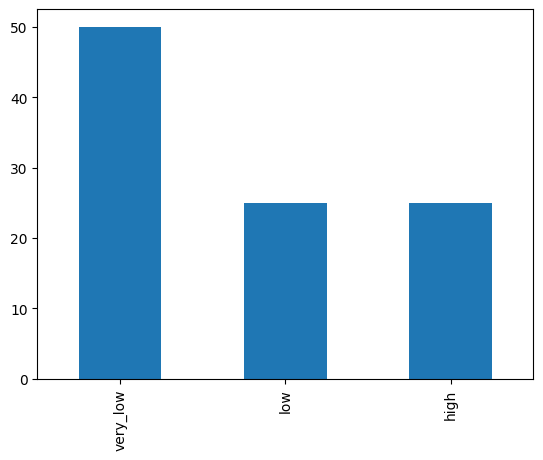

In [227]:
crime.plot()

## %% [markdown]
# ### CRIMEカテゴリの数値変換

<Axes: >

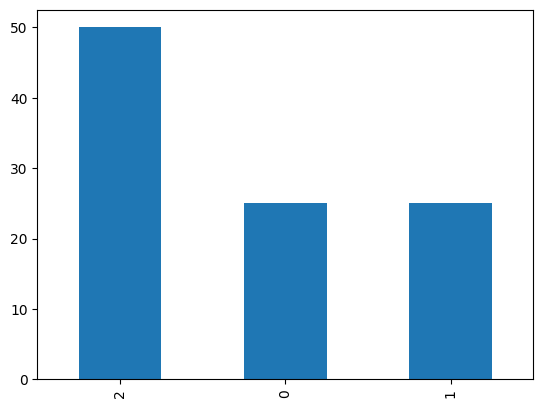

In [228]:
categorical_cols = ['CRIME']
df_conv = convert_categoricals(df, categorical_cols)
conv_species = CategoricalData(df_conv, 'CRIME')
conv_species.plot()

 ### ダミー変数化

In [229]:
df_dummy = crime.dummy()
df_dummy

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,CRIME_high,CRIME_low,CRIME_very_low
0,0.0,18.10,0,0.718,3.561,87.9,1.6132,24.0,666,20.2,354.70,7.12,27.5,1,0,0
1,0.0,8.14,0,0.538,5.950,82.0,3.9900,4.0,307,21.0,232.60,27.71,13.2,0,1,0
2,82.5,2.03,0,0.415,6.162,38.4,6.2700,2.0,348,14.7,393.77,7.43,24.1,0,0,1
3,0.0,21.89,0,0.624,6.151,97.9,1.6687,4.0,437,21.2,396.90,18.46,17.8,0,1,0
4,0.0,18.10,0,0.614,6.980,67.6,2.5329,24.0,666,20.2,374.68,11.66,29.8,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,18.10,0,0.740,6.219,100.0,2.0048,24.0,666,20.2,395.69,16.59,18.4,1,0,0
96,0.0,18.10,0,0.655,5.759,48.2,3.0665,24.0,666,20.2,334.40,14.13,19.9,1,0,0
97,0.0,18.10,0,0.671,6.380,96.2,1.3861,24.0,666,20.2,396.90,23.69,13.1,1,0,0
98,0.0,9.90,0,0.544,5.914,83.2,3.9986,4.0,304,18.4,390.70,18.33,17.8,0,1,0


 ### データの可視化

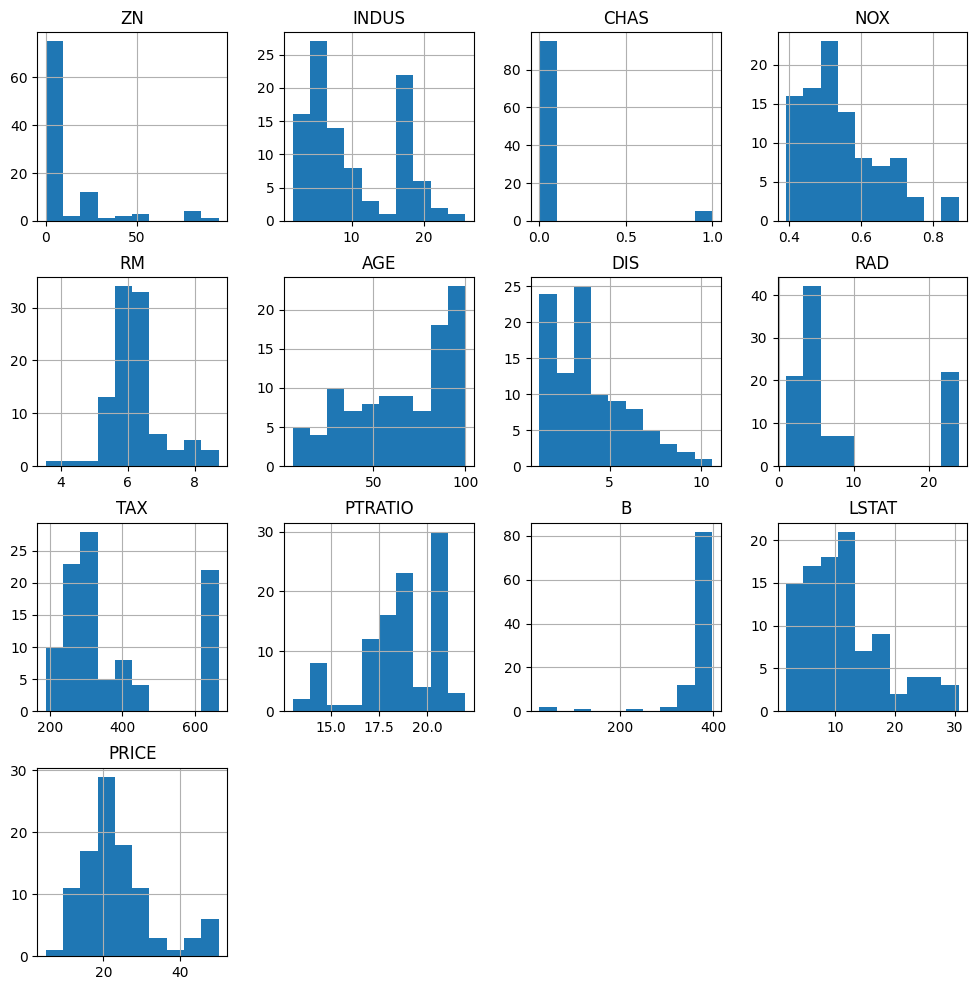

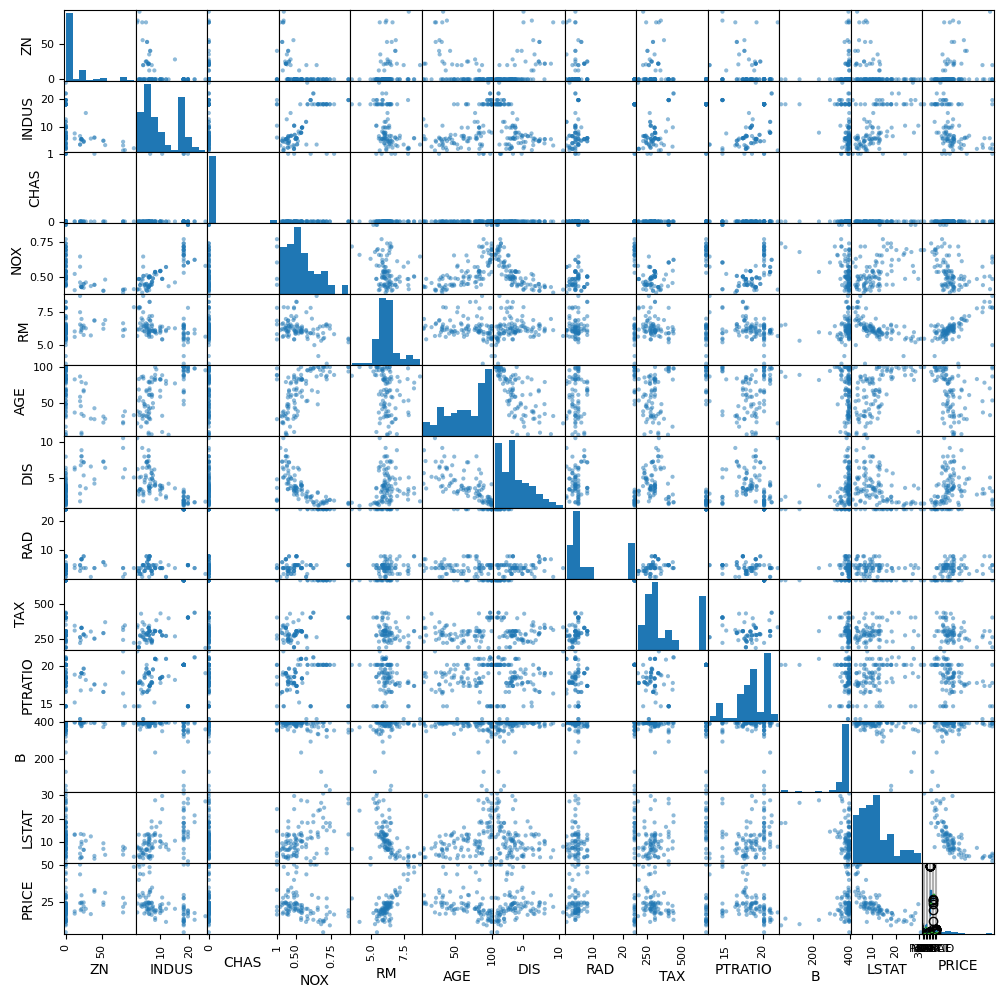

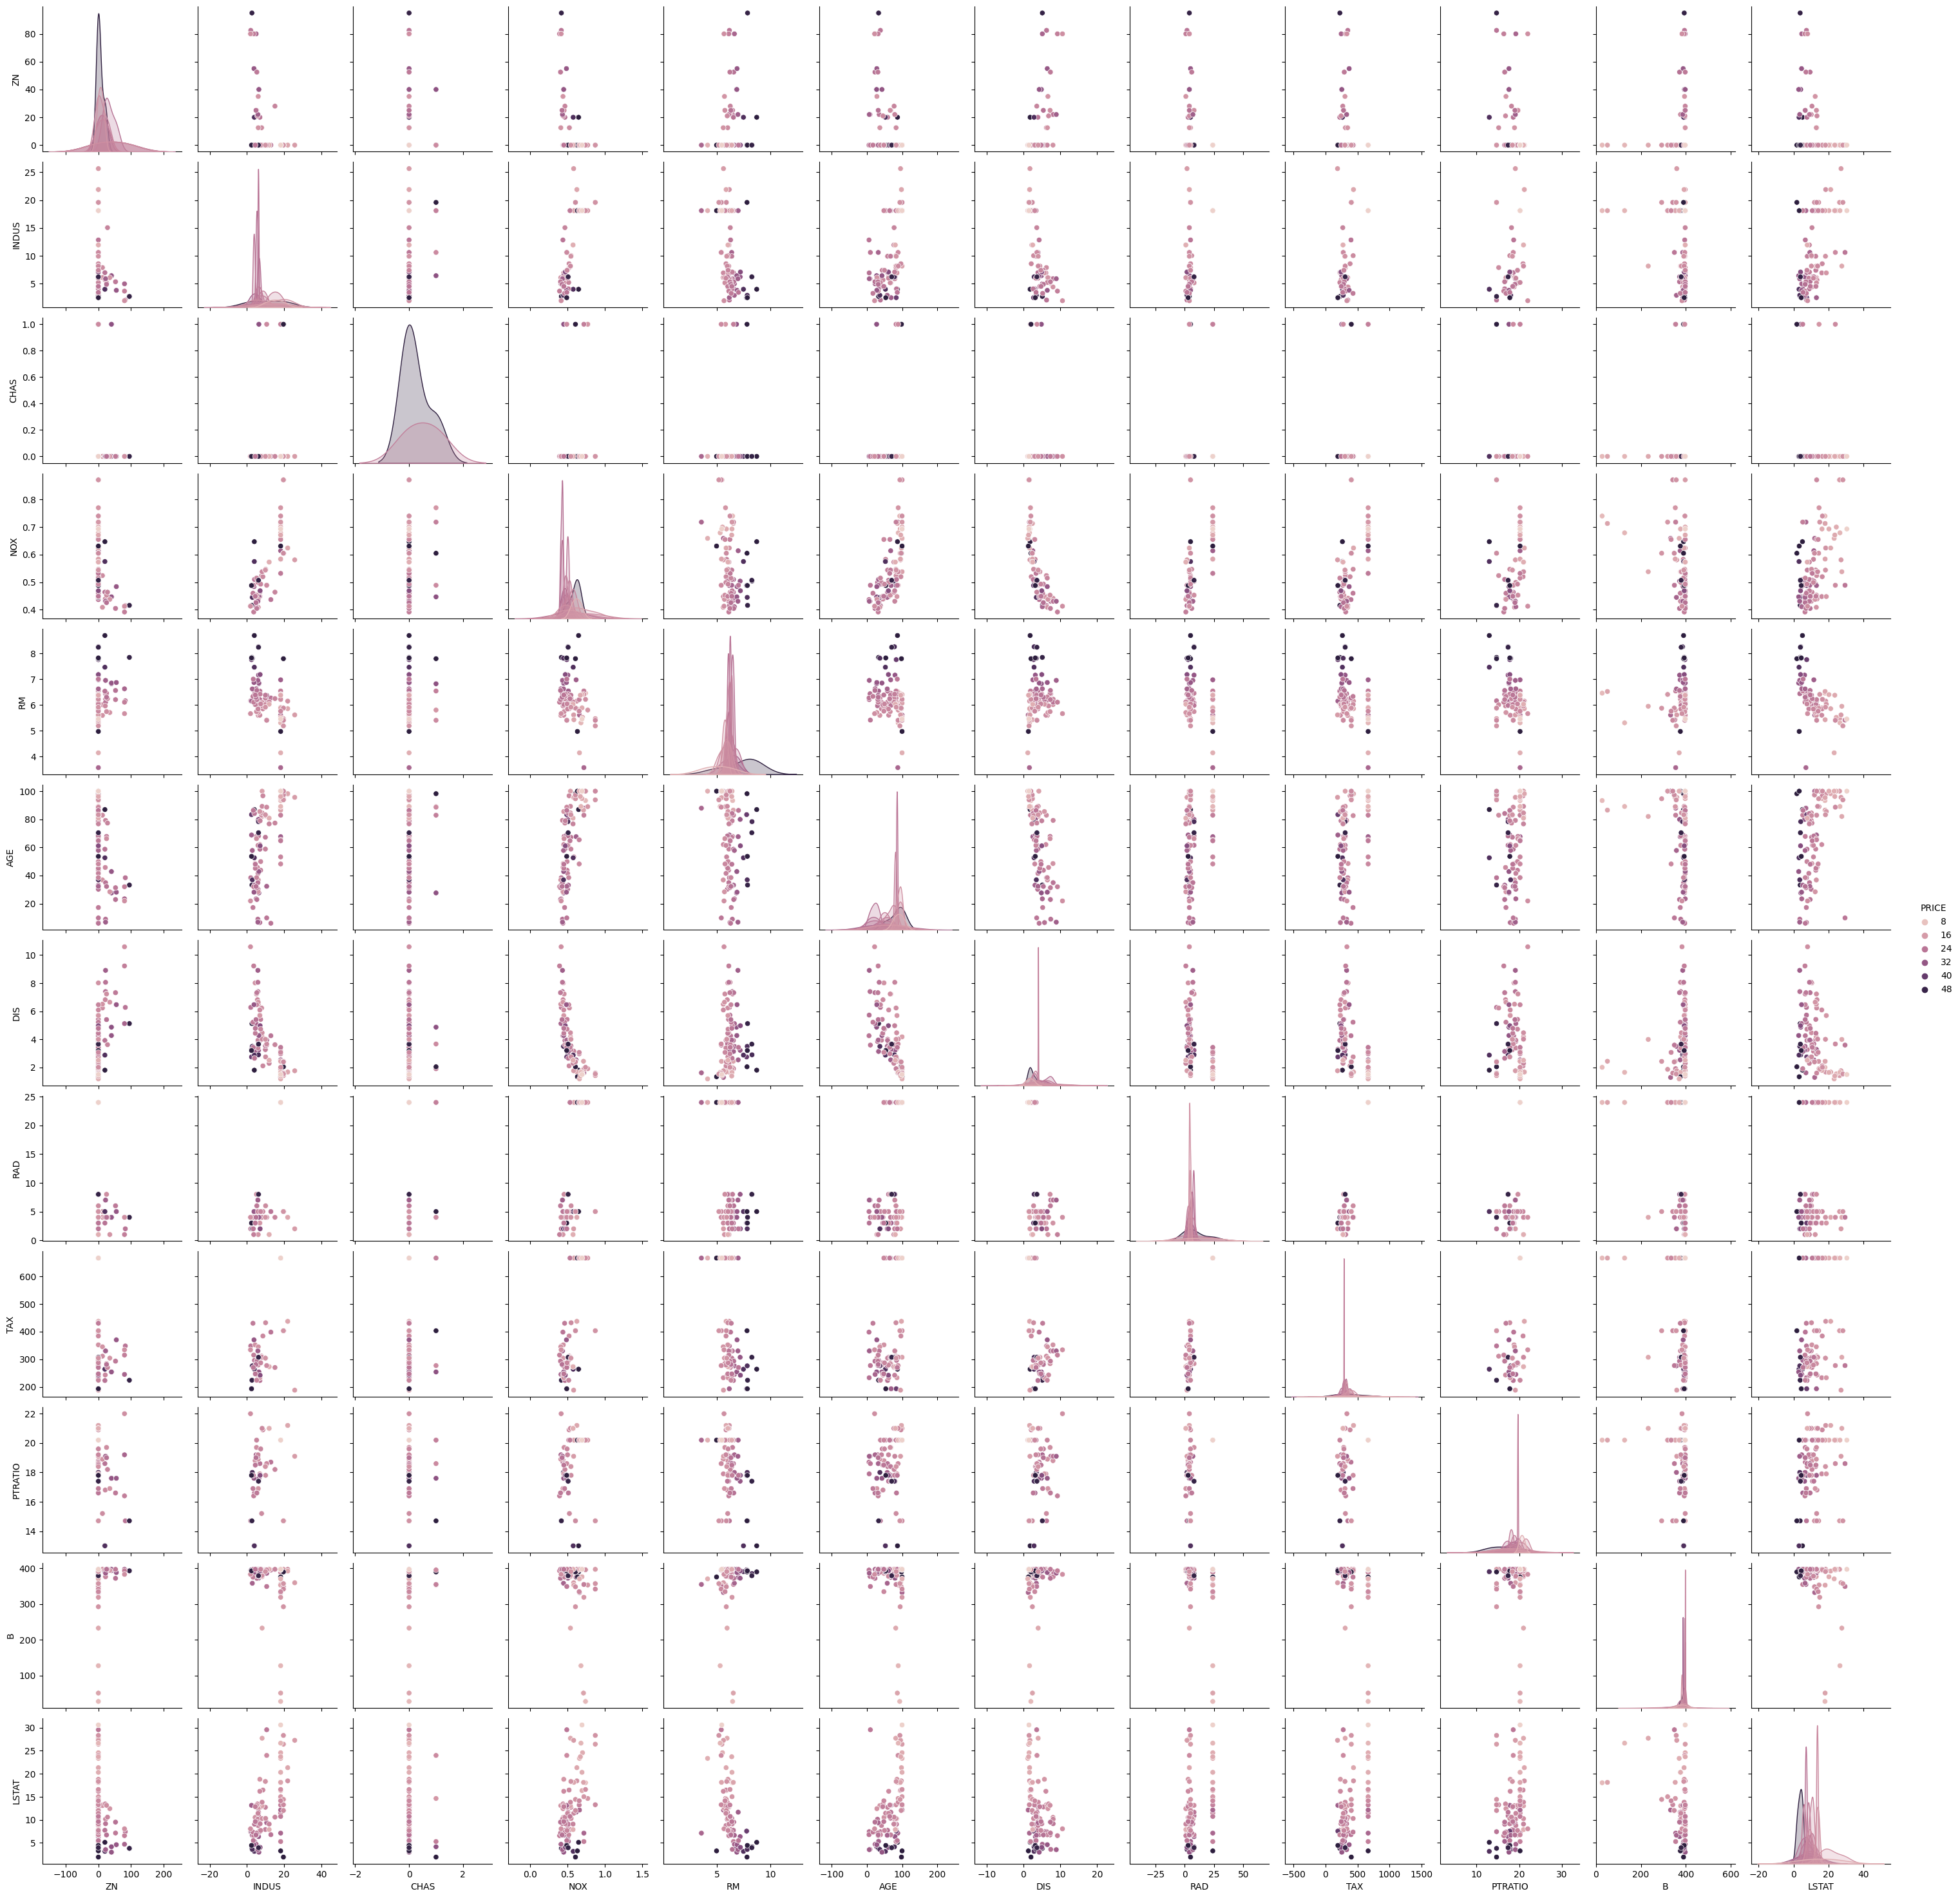

In [230]:
if VISUALIZTION:
    dv = DataVisualization(df)
    dv.df_all('PRICE')

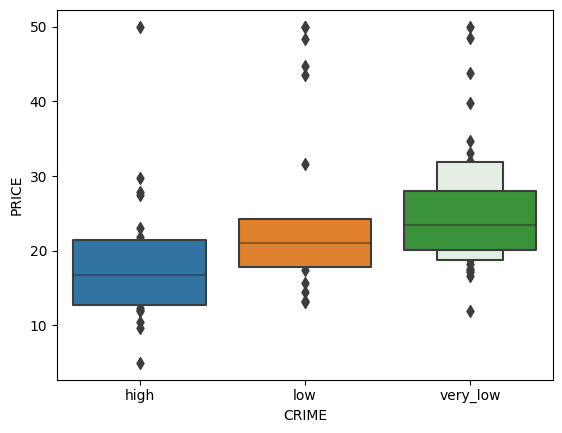

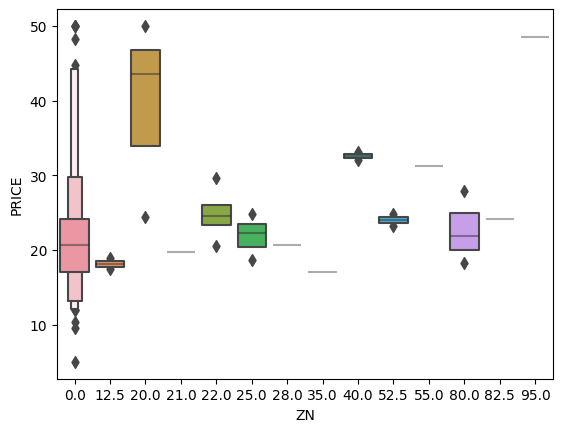

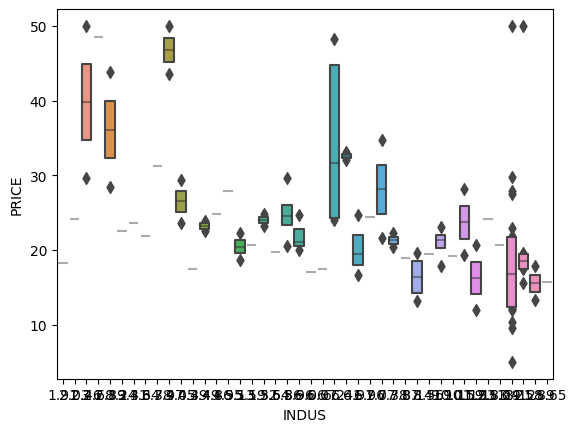

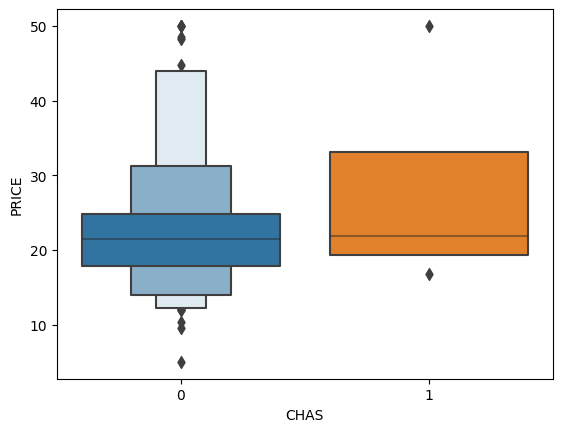

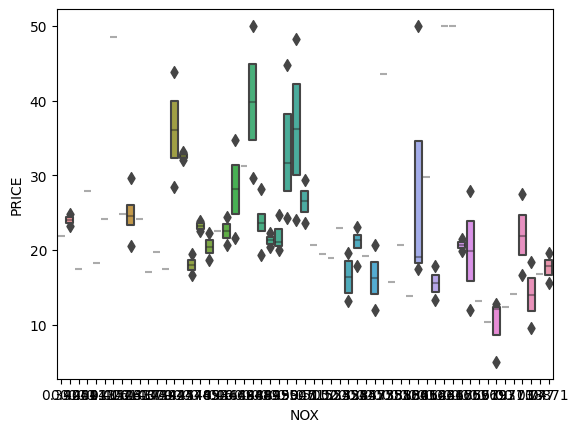

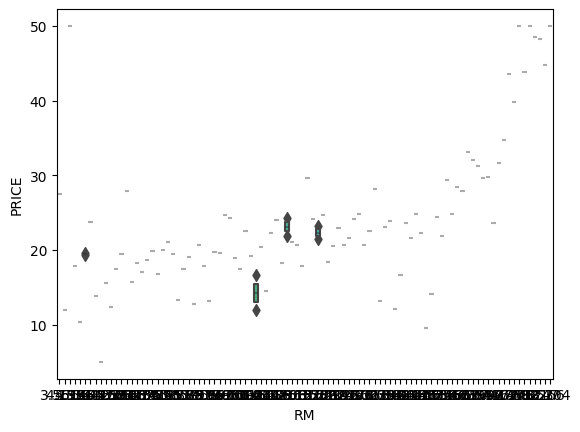

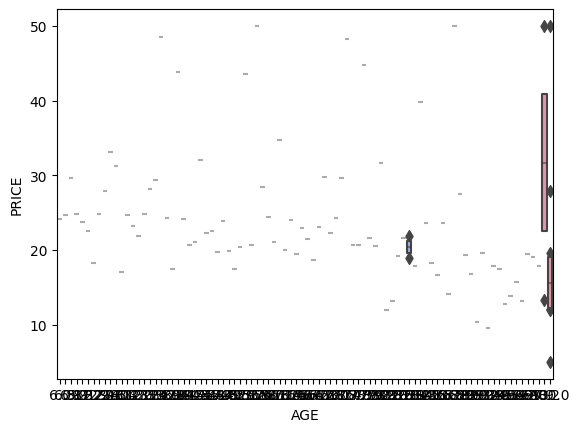

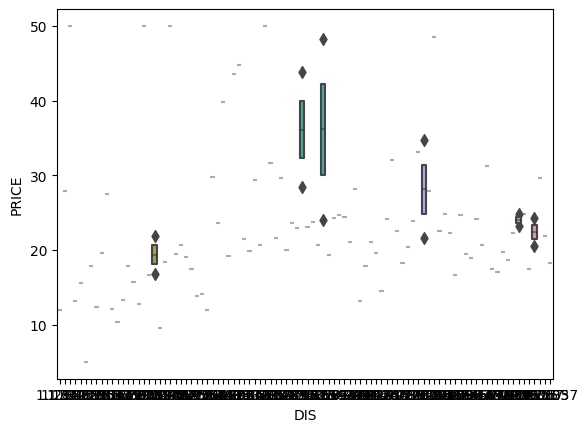

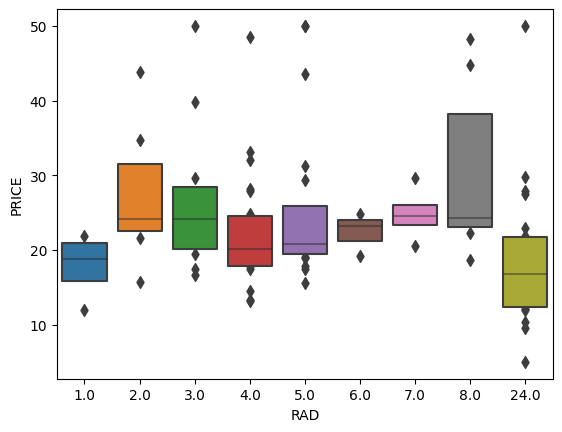

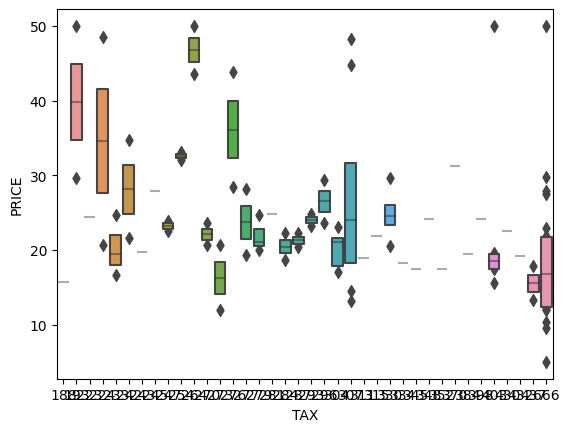

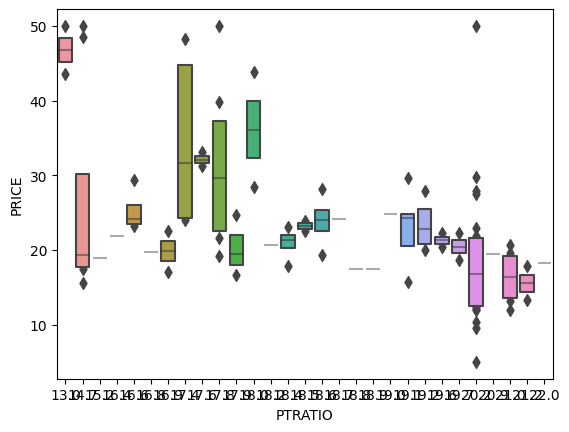

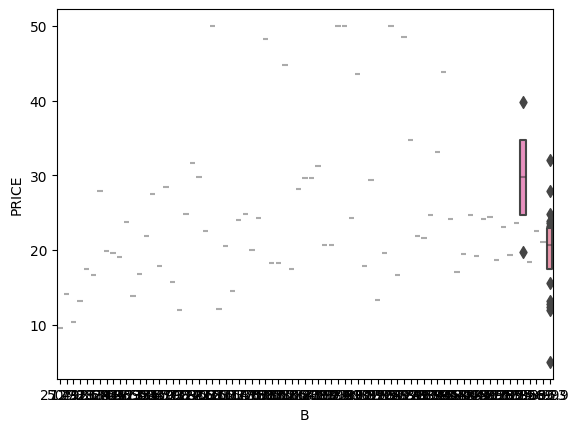

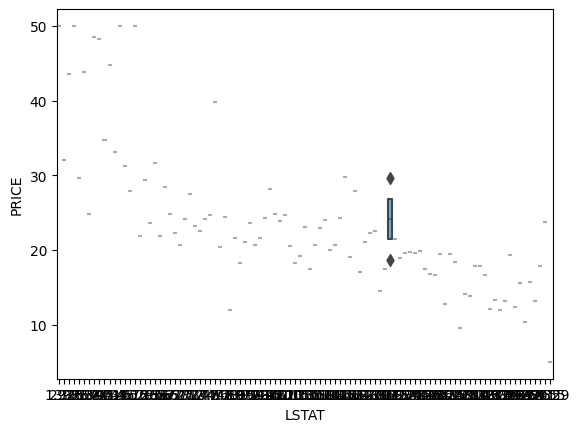

<Figure size 640x480 with 0 Axes>

In [231]:
import matplotlib.pyplot as plt
import seaborn as sns

if VISUALIZTION:
    for c in df.columns:
        plt.figure()
        if c == 'ID' or c == 'PRICE':
            continue
        sns.boxenplot(x=c, y='PRICE', data=df)

 ## データの前処理

In [232]:
df = repo.get_data()
df.head(3)

,CRIME,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,high,0.0,18.10,0,0.718,3.561,87.9,1.6132,24.0,666,20.2,354.70,7.12,27.5
1,low,0.0,8.14,0,0.538,5.950,82.0,3.9900,4.0,307,21.0,232.60,27.71,13.2
2,very_low,82.5,2.03,0,0.415,6.162,38.4,6.2700,2.0,348,14.7,393.77,7.43,24.1


In [233]:
import pandas as pd
crime = pd.get_dummies(df['CRIME'], drop_first=True)
df2 = pd.concat([df, crime], axis=1)
df2 = df2.drop('CRIME', axis=1)
df2.head(3)

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,low,very_low
0,0.0,18.10,0,0.718,3.561,87.9,1.6132,24.0,666,20.2,354.70,7.12,27.5,0,0
1,0.0,8.14,0,0.538,5.950,82.0,3.9900,4.0,307,21.0,232.60,27.71,13.2,1,0
2,82.5,2.03,0,0.415,6.162,38.4,6.2700,2.0,348,14.7,393.77,7.43,24.1,0,1


In [234]:
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df2, test_size=0.2, random_state=123)

 ### 欠損値処理（行削除・全体代表値埋め、グループ代表値埋め）

c:\Users\kakim\Projects\github\k2works\programing_introduce_2023\.venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


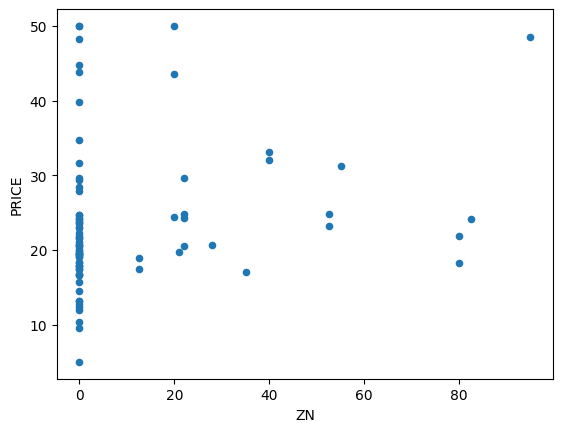

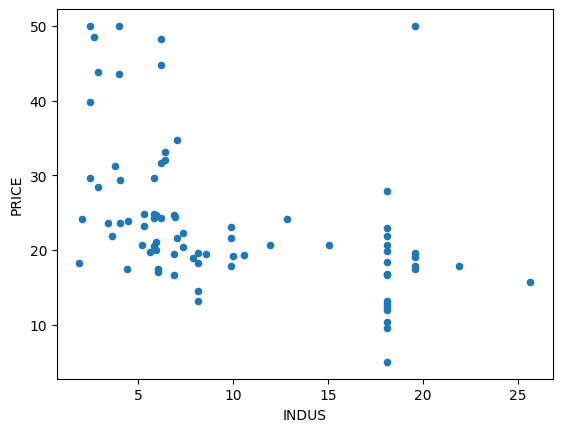

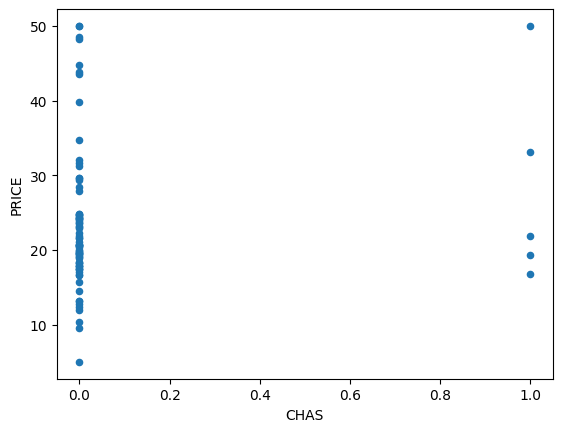

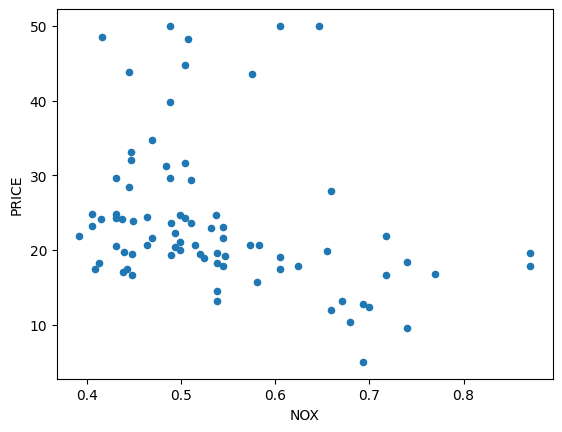

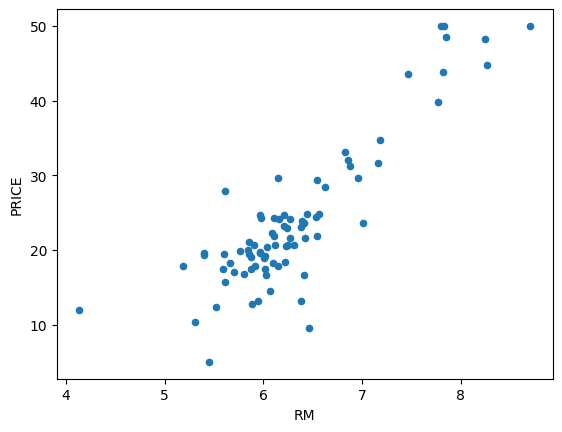

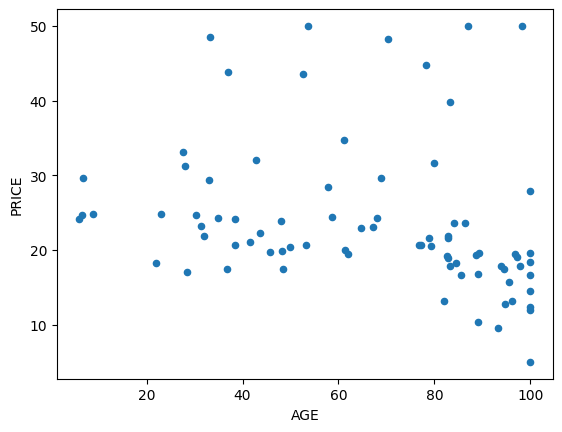

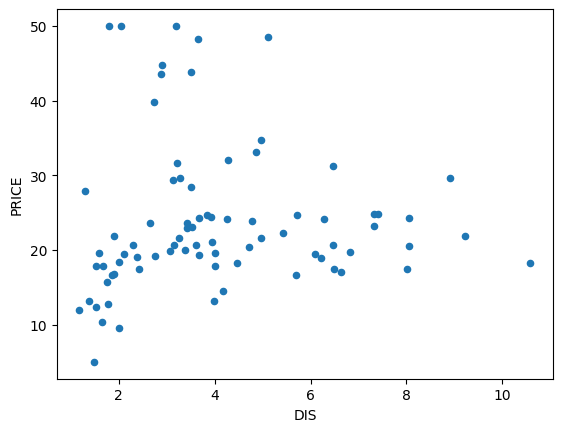

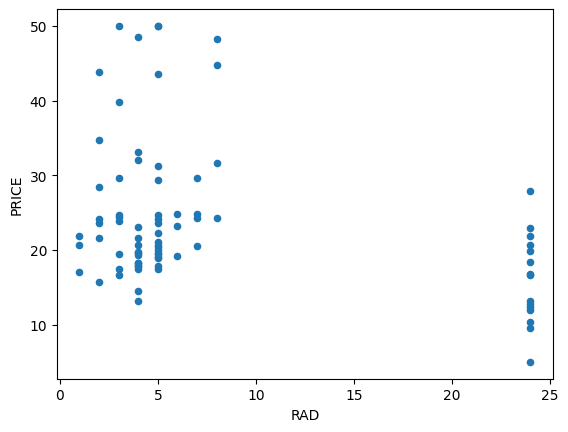

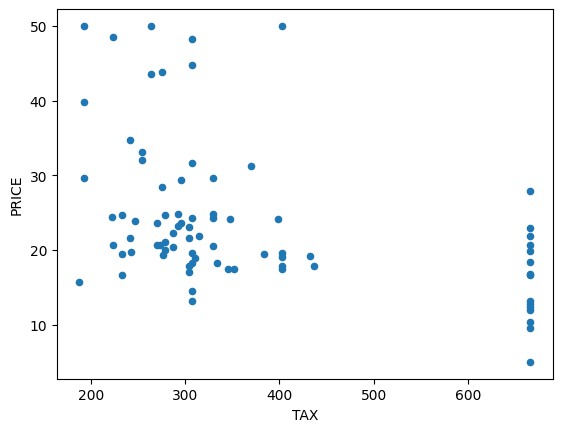

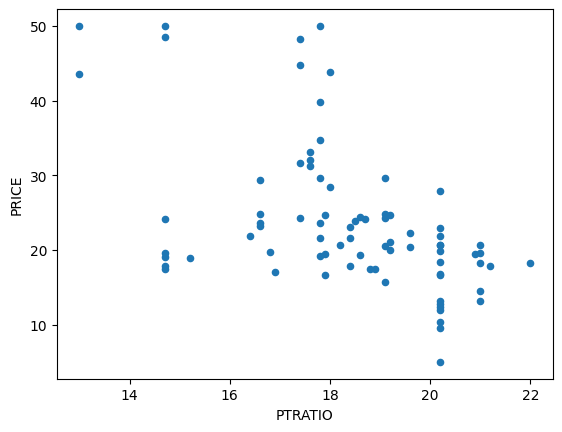

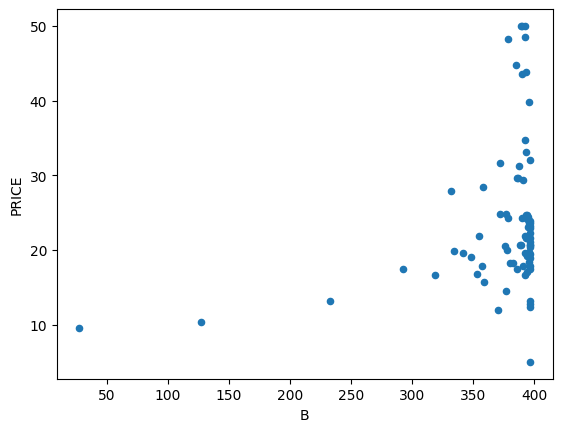

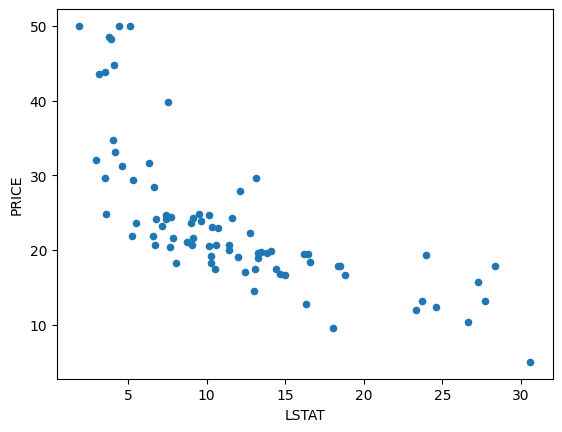

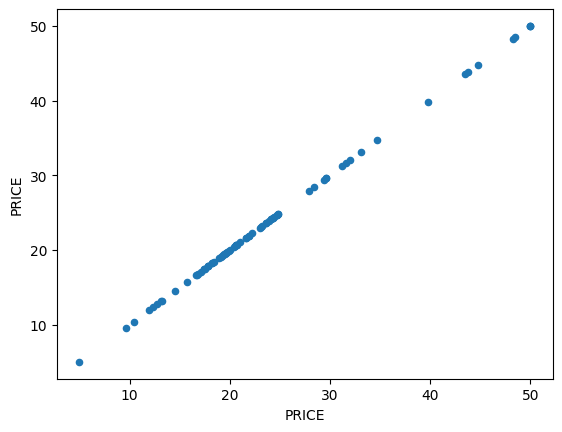

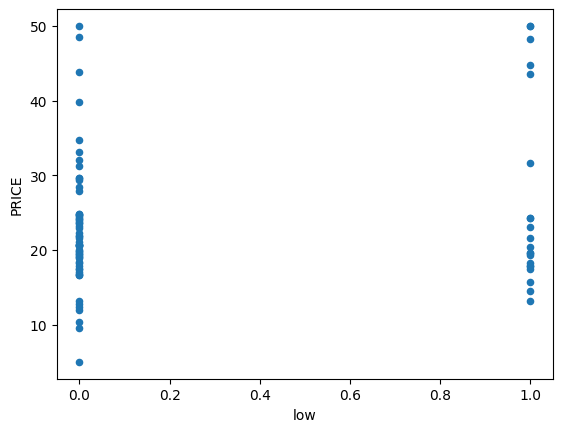

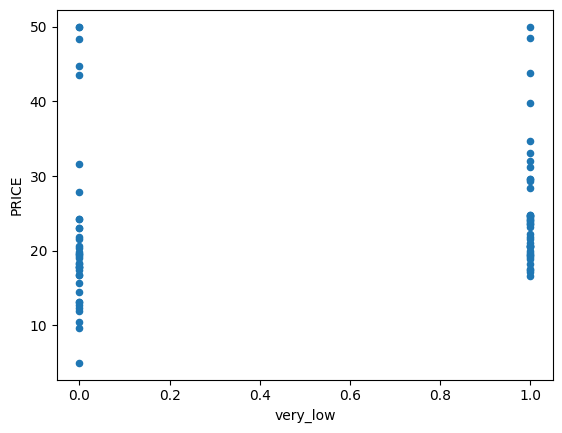

In [235]:
train_val_mean = train_val.mean()
train_val2 =  train_val.fillna(train_val_mean)

colname = train_val2.columns
for name in colname:
    train_val2.plot(kind='scatter', x=name, y='PRICE')

 ### 各手法を必要に応じて実施

 - 外れ値の除外
 - 多項式特徴量・交互作用特徴量の追加
 - 特徴量の絞り込み
 - 標準化

In [236]:
out_line1 = train_val2[(train_val2['RM'] < 6) & (train_val2['PRICE'] > 40)].index
out_line2 = train_val2[(train_val2['PTRATIO'] > 18) & (train_val2['PRICE'] > 40)].index
print(out_line1, out_line2)

Int64Index([], dtype='int64') Int64Index([], dtype='int64')


In [237]:
train_val3 = train_val2.drop(out_line1)
col = ['INDUS', 'NOX', 'RM', 'PTRATIO', 'LSTAT', 'PRICE']

train_val4 = train_val3[col]
train_val4.head(3)

,INDUS,NOX,RM,PTRATIO,LSTAT,PRICE
35,2.46,0.488,7.765,17.8,7.56,39.8
88,18.10,0.659,4.138,20.2,23.34,11.9
19,8.14,0.538,6.072,21.0,13.04,14.5


In [238]:
train_cor = train_val4.corr()['PRICE']
abs_cor = train_cor.map(abs)
abs_cor.sort_values(ascending=False)

PRICE      1.000000
RM         0.875532
LSTAT      0.716529
PTRATIO    0.522731
INDUS      0.454504
NOX        0.303965
Name: PRICE, dtype: float64

In [239]:
col = ['RM', 'LSTAT', 'PTRATIO']
x = train_val4[col]
t = train_val4[['PRICE']]

x_train, x_val, y_train, y_val = train_test_split(x, t, test_size=0.2, random_state=0)

In [240]:
from sklearn.preprocessing import StandardScaler

sc_model_x = StandardScaler()
sc_model_x.fit(x_train)
sc_x = sc_model_x.transform(x_train)

sc_model_y = StandardScaler()
sc_model_y.fit(y_train)
sc_y = sc_model_y.transform(y_train)

 ## モデルの作成と学習

 ### 未学習状態モデルの生成（分類なら決定木、回帰なら線形回帰）

In [241]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

 ### 訓練データで学習（必要に応じて不均衡データ補正）

In [242]:
model.fit(sc_x, sc_y)

LinearRegression()

 ## モデルの評価

 ### 検証データで評価し指標確認（分類なら正解率、回帰なら決定係数）

In [243]:
sc_x_val = sc_model_x.transform(x_val)
sc_y_val = sc_model_y.transform(y_val)
model.score(sc_x_val, sc_y_val)

0.884127644087128

 ### NG:改善案検討前処理に戻る

 ### Take1

In [244]:
# モデルの作成と学習
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from domain import SQLRepository,CSVRepository, convert_categoricals, CategoricalData, DataVisualization

path = os.path.dirname(os.path.abspath(__file__))
#repo = SQLRepository(table='Boston')
repo = CSVRepository(file=path + '/data/Boston.csv')

def learn(x,t):
    x_train, x_val, y_train, y_val = train_test_split(x, t, test_size=0.2, random_state=0)
    # 訓練データを標準化
    sc_model_x = StandardScaler()
    sc_model_y = StandardScaler()
    sc_model_x.fit(x_train)
    sc_x_train = sc_model_x.transform(x_train)
    sc_model_y.fit(y_train)
    sc_y_train = sc_model_y.transform(y_train)
    # 学習
    model = LinearRegression()
    model.fit(sc_x_train, sc_y_train)

    # 検証データを標準化
    sc_x_val = sc_model_x.transform(x_val)
    sc_y_val = sc_model_y.transform(y_val)
    # 訓練データと検証データの決定係数計算
    train_score = model.score(sc_x_train, sc_y_train)
    val_score = model.score(sc_x_val, sc_y_val)

    return train_score, val_score


# データの前処理
df = repo.get_data()

import pandas as pd
crime = pd.get_dummies(df['CRIME'], drop_first=True)
df2 = pd.concat([df, crime], axis=1)
df2 = df2.drop('CRIME', axis=1)

from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df2, test_size=0.2, random_state=0)

train_val_mean = train_val.mean()
train_val2 =  train_val.fillna(train_val_mean)

out_line1 = train_val2[(train_val2['RM'] < 6) & (train_val2['PRICE'] > 40)].index
out_line2 = train_val2[(train_val2['PTRATIO'] > 18) & (train_val2['PRICE'] > 40)].index
train_val3 = train_val2.drop([76], axis=0)

col = ['INDUS', 'NOX', 'RM', 'PTRATIO', 'LSTAT', 'PRICE']
train_val4 = train_val3[col]
train_val4.head(3)

train_cor = train_val4.corr()['PRICE']
abs_cor = train_cor.map(abs)
abs_cor.sort_values(ascending=False)

# モデルの評価とチューニング
x = train_val3.loc[ : ,['RM', 'LSTAT', 'PTRATIO']]
t = train_val3[['PRICE']]

s1,s2 = learn(x, t)
print(s1, s2)

0.7175897572515981 0.7359028880291


 ### Take1
 - 特徴量にINDUS列を追加

In [245]:
x = train_val3.loc[ : ,['RM', 'LSTAT', 'PTRATIO', 'INDUS']]
t = train_val3[['PRICE']]
s1,s2 = learn(x, t)
print(s1, s2)

0.7190252930186809 0.7295535344941491


 ### Take2
 - RM列のデータを2乗した新しい列を追加

In [246]:
x = train_val3.loc[ : ,['RM', 'LSTAT', 'PTRATIO']]
t = train_val3[['PRICE']]
x['RM2'] = x['RM'] ** 2
s1,s2 = learn(x, t)
print(s1, s2)

0.8456207631185566 0.8372526287986779


 ### Take3
 - RM列のデータを2乗した新しい列を追加
 - LSTAT列のデータを2乗した新しい列を追加

In [247]:
x = train_val3.loc[ : ,['RM', 'LSTAT', 'PTRATIO']]
t = train_val3[['PRICE']]
x['RM2'] = x['RM'] ** 2
x['LSTAT2'] = x['LSTAT'] ** 2
s1,s2 = learn(x, t)
print(s1, s2)

0.8565689444345093 0.8425282632102129


 ### Take4
 - RM列のデータを2乗した新しい列を追加
 - LSTAT列のデータを2乗した新しい列を追加
 - PTRATIO列のデータを2乗した新しい列を追加

In [248]:
x = train_val3.loc[ : ,['RM', 'LSTAT', 'PTRATIO']]
t = train_val3[['PRICE']]
x['RM2'] = x['RM'] ** 2
x['LSTAT2'] = x['LSTAT'] ** 2
x['PTRATIO2'] = x['PTRATIO'] ** 2
s1,s2 = learn(x, t)
print(s1, s2)

0.864383498898444 0.8678022326740726


 ### Take5
 - RM列のデータを2乗した新しい列を追加
 - LSTAT列のデータを2乗した新しい列を追加
 - PTRATIO列のデータを2乗した新しい列を追加
 - 交差作用特徴量を追加

In [249]:
x = train_val3.loc[ : ,['RM', 'LSTAT', 'PTRATIO']]
t = train_val3[['PRICE']]
x['RM2'] = x['RM'] ** 2
x['LSTAT2'] = x['LSTAT'] ** 2
x['PTRATIO2'] = x['PTRATIO'] ** 2
x['RM * LSTAT'] = x['RM'] * x['LSTAT']
s1,s2 = learn(x, t)
print(s1, s2)

0.8668534967796697 0.8739347357775972


 ### OK:最終性能評価（テストデータで評価）

 ### Take5
 - RM列のデータを2乗した新しい列を追加
 - LSTAT列のデータを2乗した新しい列を追加
 - PTRATIO列のデータを2乗した新しい列を追加
 - 交差作用特徴量を追加

In [250]:
sc_model_x2 = StandardScaler()
sc_model_x2.fit(x)
sc_x = sc_model_x2.transform(x)

sc_model_y2 = StandardScaler()
sc_model_y2.fit(t)
sc_y = sc_model_y2.transform(t)
model = LinearRegression()
model.fit(sc_x, sc_y)

LinearRegression()

In [251]:
test2 = test.fillna(train_val.mean())
x_test = test2.loc[:, ['RM', 'LSTAT', 'PTRATIO']]
y_test = test2[['PRICE']]

x_test['RM2'] = x_test['RM'] ** 2
x_test['LSTAT2'] = x_test['LSTAT'] ** 2
x_test['PTRATIO2'] = x_test['PTRATIO'] ** 2

x_test['RM * LSTAT'] = x_test['RM'] * x_test['LSTAT']

sc_x_test = sc_model_x2.transform(x_test)
sc_y_test = sc_model_y2.transform(y_test)

In [252]:
model.score(sc_x_test, sc_y_test)

0.7649249353669053

In [253]:
import pickle
with open(path + '/data/boston.pkl', mode='wb') as fp:
    pickle.dump(model, fp)
with open(path + '/data/boston_scx.pkl', mode='wb') as fp:
    pickle.dump(sc_model_x2, fp)
with open(path + '/data/boston_scy.pkl', mode='wb') as fp:
    pickle.dump(sc_model_y2, fp)

In [254]:
doctest.testmod(verbose=True)
unittest.main(argv=[''], verbosity=2, exit=False)

4 items had no tests:
    __main__
    __main__.__VSCODE_compute_hash
    __main__.__VSCODE_wrap_run_cell
    __main__.learn
0 tests in 4 items.
0 passed and 0 failed.
Test passed.



----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK
